In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#path = 'netcdf_sound_files/SB03/soundcoop_SanctSound_SanctSound_SB03_08_HMD_SB03_08_1677758490.1.48000_20200131_DAILY_MILLIDEC_MinRes.nc'
folder_path = 'netcdf_sound_files/SB03/*.nc'

Set resample resolution. Will be applied to environmental dataset and sound dataset

In [3]:
RESAMPLE_RESOLUTION = 'h'

Read in folder of NETCDF files pulled from google cloud

In [4]:
sound_xr =  xr.open_mfdataset('netcdf_sound_files/SB03/*.nc', drop_variables = ('psd_image_colormap', 'psd_image', 'percentile_image','percentile_image_colormap'))


In [5]:
sound_xr = sound_xr.where(sound_xr.quality_flag == 1, drop=True)

In [6]:
#sound_xr[dict(quality_flag=1)]
#sound_xr.where(sound_xr.quality_flag > 1)
#sound_xr.isel(quality_flag=1)
#sound_xr.isel(quality_flag=1)
#sound_xr.where(sound_xr.quality_flag == 1, drop=True)

Resample sound data

In [7]:
sound_xr_resampled = sound_xr.psd.resample(time=RESAMPLE_RESOLUTION).median()

Set up ERDDAP data feed

In [8]:
ERDDAP_INSTALL = 'https://erddap.sensors.ioos.us/erddap'
ERDDAP_DATASET = 'wmo_44013'
TIME_START = np.datetime_as_string(sound_xr.time.min().to_pandas())
TIME_END = np.datetime_as_string(sound_xr.time.max().to_pandas())
WIND_VARIABLE = 'wind_speed'
WT_VARIABLE = 'sea_water_temperature'
WAVE_VARIABLE = 'sea_surface_wave_significant_height'
URL = ERDDAP_INSTALL + '/tabledap/' + ERDDAP_DATASET + '.csv?time,' + WIND_VARIABLE + ',' + WT_VARIABLE + ',' + WAVE_VARIABLE + '&time>=' + TIME_START + '&time<=' + TIME_END

Read in ERDDAP feed

In [9]:
#df = pd.read_csv(URL, skiprows=[1])
#df['time'] = pd.to_datetime(df['time'])
#df = df.set_index('time').sort_index()
#resampled_variable_data = df.dropna().resample(RESAMPLE_RESOLUTION).agg(['min','max','mean','count'])

erddap_df = pd.read_csv(URL, skiprows=[1])
erddap_df['time'] = pd.to_datetime(erddap_df['time'])
erddap_df = erddap_df.set_index('time').sort_index()

Read ERDDAP dataframe into xarray and resample so it can be merged with sound data

In [10]:
erddap_xr = erddap_df.to_xarray()
erddap_xr['time'] = pd.DatetimeIndex(erddap_xr['time'].values)
erddap_xr_resampled = erddap_xr.resample(time=RESAMPLE_RESOLUTION).mean()

In [11]:
erddap_xr_resampled

<xarray.Dataset>
Dimensions:                              (time: 1589)
Coordinates:
  * time                                 (time) datetime64[ns] 2020-01-31T19:...
Data variables:
    wind_speed                           (time) float64 1.0 1.0 4.0 ... 4.0 5.0
    sea_water_temperature                (time) float64 5.5 5.5 5.5 ... 6.7 6.5
    sea_surface_wave_significant_height  (time) float64 0.35 0.3 ... 1.0 1.05

Merge sound data with environmental (ERDDAP) data

In [12]:
sound_and_erddap_merged = xr.merge([sound_xr_resampled,erddap_xr_resampled])

In [13]:
sound_and_erddap_merged.to_netcdf('sample-merged.nc')

In [14]:
sample_merged =  xr.open_mfdataset('sample-merged.nc')

In [15]:
sample_merged

<xarray.Dataset>
Dimensions:                              (time: 1589, frequency: 2157)
Coordinates:
  * time                                 (time) datetime64[ns] 2020-01-31T19:...
  * frequency                            (frequency) float64 21.0 ... 2.4e+04
Data variables:
    psd                                  (time, frequency) float64 dask.array<chunksize=(1589, 2157), meta=np.ndarray>
    wind_speed                           (time) float64 dask.array<chunksize=(1589,), meta=np.ndarray>
    sea_water_temperature                (time) float64 dask.array<chunksize=(1589,), meta=np.ndarray>
    sea_surface_wave_significant_height  (time) float64 dask.array<chunksize=(1589,), meta=np.ndarray>

In [16]:
sample_merged.close()

Method that reshapes merged and filtered dataset to allow for power spec plot

In [17]:
def reshape_merged_and_filtered_into_flattened_dataframe(filtered,spColumnName):
    mf_psd = filtered.psd
    mf_pd = mf_psd.to_pandas()
    mf_pd = mf_pd.reset_index()
    mf_pd = mf_pd.drop(columns=['time'])
    mf_pd = mf_pd.reset_index()
    mf_pd.columns = ["_" + str(c) for c in mf_pd.columns]
    mf_pd = mf_pd.drop(columns=['_index'])
    mf_pd['id'] = mf_pd.index
    mf_pd = mf_pd.dropna()

    mf_flat = pd.wide_to_long(mf_pd, "_", i='id', j='frequency', suffix='.*')
    mf_flat = mf_flat.reset_index()
    mf_flat[spColumnName] = mf_flat['_']
    mf_flat = mf_flat.drop(columns=['id','_'])
    return mf_flat.groupby('frequency').mean()


In [18]:
filtered = sound_and_erddap_merged.where((sound_and_erddap_merged.wind_speed > 11.5) & (sound_and_erddap_merged.wind_speed <= 23))
mf_psd = filtered.psd
mf_pd = mf_psd.to_pandas()
mf_pd = mf_pd.reset_index()
mf_pd = mf_pd.drop(columns=['time'])
mf_pd = mf_pd.reset_index()
mf_pd.columns = ["_" + str(c) for c in mf_pd.columns]
mf_pd = mf_pd.drop(columns=['_index'])
mf_pd['id'] = mf_pd.index
mf_pd = mf_pd.dropna()
mf_flat = pd.wide_to_long(mf_pd, "_", i='id', j='frequency', suffix='.*')
mf_flat

,,_
id,frequency,
168,21.0,84.35
169,21.0,86.95
170,21.0,86.40
171,21.0,84.30
172,21.0,83.25
...,...,...
1524,24000.0,46.10
1525,24000.0,47.05
1526,24000.0,45.60


# Plots

Spectrogram

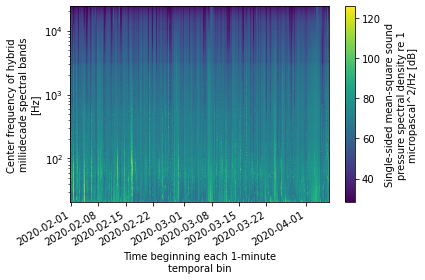

In [19]:
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sound_xr.psd.plot(x='time', yscale='log')
plt.show()

Powerspec filtered on winds greater than 5mph and less than 10mph

In [20]:
def create_powerspec_plot(data,filter_statement, label, ylabel, xlabel, ax=None):
    filtered = data.where(filter_statement)
    return reshape_merged_and_filtered_into_flattened_dataframe(filtered,label)\
        .plot(logx=True, ylabel=ylabel, xlabel=xlabel, ax=ax)
    
    
    

# Wind

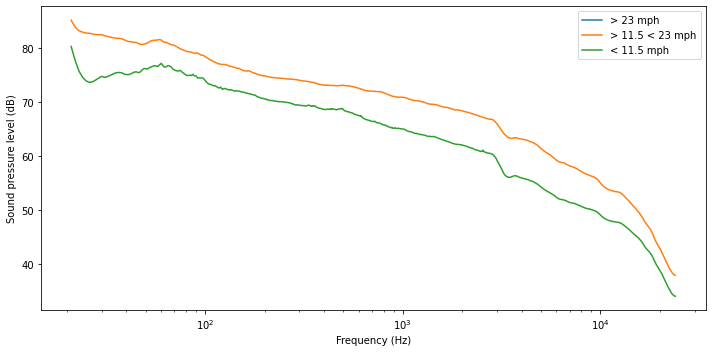

In [21]:
xlabel = 'Frequency (Hz)'
ylabel = 'Sound pressure level (dB)'
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True

ax = create_powerspec_plot(
   sound_and_erddap_merged,
   (sound_and_erddap_merged.wind_speed > 23),
   '> 23 mph',
    ylabel,
    xlabel
)

create_powerspec_plot(
   sound_and_erddap_merged,
   (sound_and_erddap_merged.wind_speed > 11.5) & (sound_and_erddap_merged.wind_speed <= 23),
   '> 11.5 < 23 mph',
    ylabel,
    xlabel,
    ax
)

create_powerspec_plot(
   sound_and_erddap_merged,
   (sound_and_erddap_merged.wind_speed <= 11.5),
   '< 11.5 mph',
    ylabel,
    xlabel,
    ax
)

plt.show()


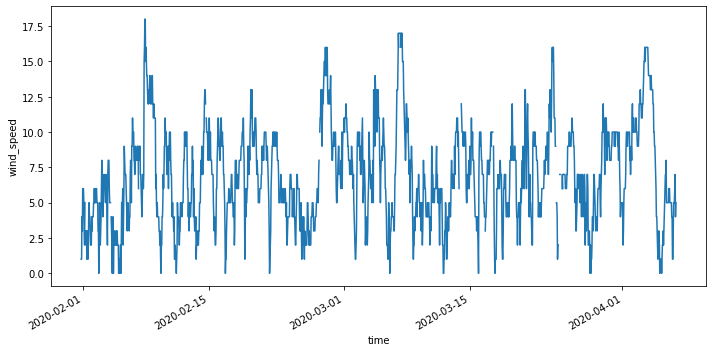

In [22]:
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True
erddap_xr_resampled[WIND_VARIABLE].plot()
plt.show()


# Waves

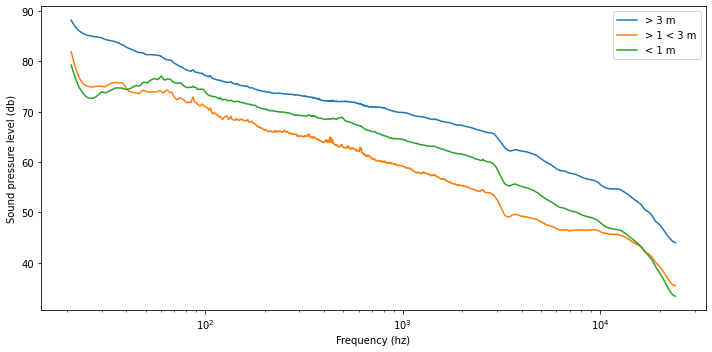

In [23]:
xlabel = 'Frequency (hz)'
ylabel = 'Sound pressure level (db)'
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True

ax = create_powerspec_plot(
   sound_and_erddap_merged,
   (sound_and_erddap_merged[WAVE_VARIABLE] > 3),
   '> 3 m',
    ylabel,
    xlabel
)

create_powerspec_plot(
   sound_and_erddap_merged,
   (sound_and_erddap_merged[WAVE_VARIABLE] > 1) & (sound_and_erddap_merged.wind_speed <= 3),
   '> 1 < 3 m',
    ylabel,
    xlabel,
    ax
)

create_powerspec_plot(
   sound_and_erddap_merged,
   (sound_and_erddap_merged[WAVE_VARIABLE] <= 1),
   '< 1 m',
    ylabel,
    xlabel,
    ax
)

plt.show()

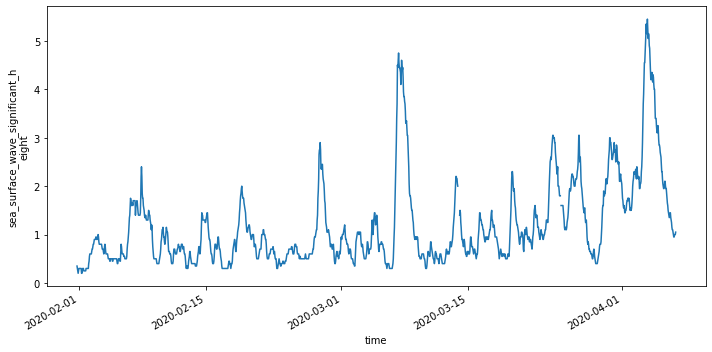

In [24]:
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True
erddap_xr_resampled[WAVE_VARIABLE].plot()
plt.show()

# Water temperature

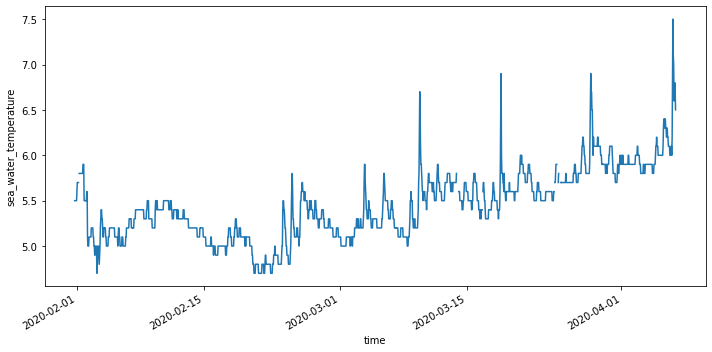

In [25]:
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True
erddap_xr_resampled[WT_VARIABLE].plot()
plt.show()